# Setup

La idea de este notebook es evaluar el modelo en un contexto más acotado, a diferencia del "one fold" donde pediamos que ordene la lista completa de genes. 

En lugar de hacer un sampleo al azar para generar la muestra acotada, voy a usar vecindades genómicas y topológicas para achicar el espacio de búsqueda. 

In [1]:
import pandas as pd
import numpy as np
import json
import torch
import pickle
from torch_geometric import seed_everything
import networkx as nx

import sys
sys.path.append("../../..")
from src.models import training_utils, final_model, prediction_utils

seed = 4
seed_everything(4)

data_folder = "../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
feature_folder = "../../../data/processed/feature_data/"
reports_folder = "../../../reports/"
models_folder = "../../../models/final_model/"

Load data and model weights

In [3]:
with open("../../../data/external/genomic_neighbors.json") as json_file:
    neighbors_json = json.load(json_file)

genomic_neighbors = pd.DataFrame(neighbors_json.values())
genomic_neighbors.index =  list(neighbors_json.keys())

#load data
dataset, node_map = training_utils.load_data(data_folder+f"seed_{seed}/",load_test=True)
test_data = dataset[2]
node_df = pd.read_csv(data_folder+f"seed_{seed}/tensor_df.csv",index_col=0).set_index("node_index",drop=True)

with open(f"{models_folder}training_parameters.pickle", 'rb') as handle:
    params = pickle.load(handle)

#initialize features in test data
test_data  = training_utils.initialize_features(test_data,params["feature_type"],params["feature_dim"],feature_folder)

#load model
weights_path = models_folder+f"seeds/final_model_{seed}.pth"
weights = torch.load(weights_path)
model = final_model.Model(test_data.metadata(),[("gene_protein","gda","disease")])
model.load_state_dict(weights)

<All keys matched successfully>

# Entorno genómico

Armo para cada gen su vecindario de 99 genes más cercanos, esto me va a dar para cada uno una lista de 100 nodos que puedo priorizar con el modelo

In [4]:
nan_count = genomic_neighbors.isna().sum(axis=1)
print(f"Hay {len(nan_count[nan_count!=0])} genes con nans en su vecindario")

Hay 13 genes con nans en su vecindario


Saco los genes con NaNs porque son poquitos y también los Entrez ID que van a más de un nombre de gen (es un tema de ontologías y nomenclaturas entre base de datos, en HIPPIE figuran genes con diferentes entrez id que tienen el mismo nombre. Es ambiguo pero como pueden ser genes diferentes nos quedamos con el ID)

In [5]:
gene_mapping = node_df[node_df.node_type == "gene_protein"].reset_index()[["node_index","node_id","node_name"]]
genomic_neighbors = genomic_neighbors.dropna()
genomic_neighbors = genomic_neighbors.merge(gene_mapping,how="left", left_index=True, right_on="node_name")
genomic_neighbors = genomic_neighbors.drop_duplicates(subset="node_name",keep=False).set_index("node_name")
genomic_neighbors

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,node_index,node_id
node_name,,,,,,,,,,,,,,,,,,,,,
SAMD11,SAMD11,NOC2L,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,PUSL1,DVL1,...,ATP13A2,SDHB,PADI1,PADI3,PADI4,RCC2,ARHGEF10L,ALDH4A1,3057,148398
NOC2L,NOC2L,ISG15,SAMD11,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,PUSL1,DVL1,...,ATP13A2,SDHB,PADI1,PADI3,PADI4,RCC2,ARHGEF10L,ALDH4A1,5935,26155
ISG15,ISG15,NOC2L,SAMD11,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,PUSL1,DVL1,...,ATP13A2,SDHB,PADI1,PADI3,PADI4,RCC2,ARHGEF10L,ALDH4A1,18068,9636
AGRN,AGRN,TNFRSF18,ISG15,NOC2L,SAMD11,TNFRSF4,SDF4,B3GALT6,PUSL1,DVL1,...,ATP13A2,SDHB,PADI1,PADI3,PADI4,RCC2,ARHGEF10L,ALDH4A1,8102,375790
TNFRSF18,TNFRSF18,AGRN,TNFRSF4,SDF4,B3GALT6,PUSL1,DVL1,CCNL2,VWA1,ATAD3A,...,ATP13A2,SDHB,PADI1,PADI3,PADI4,RCC2,ARHGEF10L,ALDH4A1,16978,8784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UTY,UTY,DDX3Y,USP9Y,TBL1Y,ZFY,SPRY3,SRY,VAMP7,IL9R,CLIC2,...,ENOX2,RBMX2,AIFM1,ELF4,BCORL1,ZDHHC9,OCRL,SMARCA1,14617,7404
RPS4Y2,RPS4Y2,HSFY1,UTY,DDX3Y,USP9Y,TBL1Y,ZFY,SPRY3,SRY,VAMP7,...,RAP2C,STK26,ENOX2,RBMX2,AIFM1,ELF4,BCORL1,ZDHHC9,2662,140032
RBMY1A1,RBMY1A1,BPY2,RPS4Y2,HSFY1,UTY,DDX3Y,USP9Y,TBL1Y,ZFY,SPRY3,...,TFDP3,MBNL3,RAP2C,STK26,ENOX2,RBMX2,AIFM1,ELF4,12761,5940


In [6]:
encodings_dict = training_utils.get_encodings(model,test_data)
mapped_dataset = prediction_utils.MappedDataset(test_data,node_map,("gene_protein","gda","disease"))
mapped_df = mapped_dataset.dataframe
mapped_df = mapped_df.rename(columns={x: x.replace("_source","").replace("_target","") for x in mapped_df.columns})

predictor = prediction_utils.Predictor(node_df,encodings_dict)

Ahora necesito ver qué genes de esta lista tienen asociaciones en test

In [7]:
seen_edges = mapped_df[(mapped_df.edge_type == "message_passing")][["gene_protein","disease"]]
new_edges = mapped_df[(mapped_df.edge_type == "supervision") & (mapped_df.label == 1) ][["gene_protein","disease"]]

genes_en_test = new_edges.gene_protein.unique()
g_test_neighborhood = set(genes_en_test).intersection(genomic_neighbors.node_index.values)
print(f"Quedan {len(g_test_neighborhood)} genes con enlaces en test e información sobre vecindario genómico")

Quedan 3207 genes con enlaces en test e información sobre vecindario genómico


Veo quienes son estos genes:

In [8]:
node_df.loc[list(g_test_neighborhood),["degree_gda","degree_pp","total_degree"]].describe()

,degree_gda,degree_pp,total_degree
count,3207.000000,3207.000000,3207.000000
mean,17.241659,25.298098,42.539757
std,24.474245,39.980169,51.319309
min,1.000000,1.000000,2.000000
25%,5.000000,6.000000,15.000000
50%,10.000000,13.000000,27.000000
75%,19.000000,29.000000,50.000000
max,340.000000,625.000000,755.000000


Hay una buena mezcla de grados, tengo distintos casos para ver. Armo el DF final con estos genes y sus vecindarios:

In [9]:
gn_test = genomic_neighbors.reset_index().set_index("node_index").loc[list(g_test_neighborhood)].drop(columns=["node_id"])
gn_test

,node_name,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
node_index,,,,,,,,,,,,,,,,,,,,,
1,NAT2,NAT2,NAT1,ASAH1,PCM1,FGL1,MTUS1,MTMR7,CNOT7,VPS37A,...,CNTNAP2,CUL1,EZH2,PDIA4,GIMAP1,KRBA1,KCNH2,ATG9B,NOS3,ABCB8
2,ADA,SERINC3,ADA,WISP2,HNF4A,FITM2,TOX2,MYBL2,IFT52,SGK2,...,THBD,SSTR4,FOXA2,PAX1,XRN2,KIZ,NAA20,INSM1,DTD1,SEC23B
3,CDH2,CDH2,CHST9,AQP4,KCTD1,TAF4B,SS18,IMPACT,CABYR,LAMA3,...,CHMP6,RPTOR,NPTX1,ENDOV,RNF213,SGSH,CARD14,EIF4A3,GAA,CCDC40
4,AKT3,AKT3,SDCCAG8,ZBTB18,EXO1,OPN3,COX20,KMO,HNRNPU,FH,...,MCM10,PHYH,BEND7,FRMD4A,CDNF,HSPA14,SUV39H2,DCLRE1C,ACBD7,RPP38
8197,KPNA2,KPNA2,BPTF,NOL11,PSMD12,HELZ,CACNG5,PRKCA,CD79B,ICAM2,...,DLX4,KAT7,SPOP,NXPH3,NGFR,PHB,PHOSPHO1,ABI3,GNGT2,IGF2BP1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16373,MEGF10,MEGF10,LMNB1,PHAX,ALDH7A1,CEP120,PRDM6,SNX24,SNX2,SNCAIP,...,RASGRF2,SSBP2,ATG10,RPS23,XRCC4,VCAN,HAPLN1,EDIL3,RASA1,COX7C
8184,KLRC2,KLRC2,KLRK1,MAGOHB,KLRD1,OLR1,STYK1,PRB3,CLEC7A,ETV6,...,KCNA6,NDUFA9,AKAP3,DYRK4,C12orf4,FGF6,FGF23,TIGAR,CCND2,TEAD4
8187,KNG1,KNG1,HRG,AHSG,DNAJB11,CRYGS,ETV5,TRA2B,IGF2BP2,SENP2,...,RNF13,WWTR1,CP,HPS3,HLTF,AGTR1,ZIC1,GYG1,PLSCR1,PLSCR4


# Entorno topológico (red PPI)

Armo el entorno topológico para todos los genes con enlaces en test, para esto creo que me va a convenir usar NX. Uso el grafo que distingue complejos-proteínas para no mezclar los vecindarios genómicos con complejos. El grafo es igual solo que distingue esos tipos de nodos. 

Tengo que elegir un tipo de vecindario.. me quedo solo con la red PPI. 

In [10]:
def attributes_from_pd(G:nx.Graph,df:pd.DataFrame,attributes:dict,indexcol):
    """Dados un grafo G y un dataframe df con atributos de sus nodos, especificamos los atributos
    que queremos agregar a los nodos en un diccionario con formato {nombre_columna:nombre_atributo}. 
    La función arma un diccionario con los atributos y el nombre que le queremos poner, indexado con el identificador de nodo que elegimos 
    y los asigna a los nodos del grafo"""
    for attribute,name in attributes.items():
        nx.set_node_attributes(G,pd.Series(df.set_index(indexcol)[attribute]).to_dict(),name)

graph_edge_data = pd.read_csv("../../../data/processed/graph_data_nohubs/nohub_graph_edge_data.csv")
edges_proteinas = graph_edge_data[(graph_edge_data.edge_type == "ppi")]
nodos_proteinas = node_df[(node_df.node_type == "gene_protein")].reset_index()

PPI = nx.from_pandas_edgelist(edges_proteinas,source="x_index",target="y_index")
PPI_attributes = {"node_type":"node_type","node_name":"node_name","node_id":"node_id","node_source":"node_source"}
attributes_from_pd(PPI,nodos_proteinas,PPI_attributes,"node_index")

In [11]:
def neighborhood(G, node, k):
    """Hallar vecindario de orden k de un nodo"""
    path_lengths = nx.single_source_dijkstra_path_length(G, node)
    return [node for node, length in path_lengths.items() if length == k]

Algunos genes no van a quedar en la red PPI al sacar pathways y complejos. Por ejemplo el index 6468 tiene varias asociaciones GDA pero no tiene PPI, está conectado a la red PPI a través de un enlace con un pathway. Esos genes no van a servir para este análisis, los sacamos.

In [12]:
orden_1 = {}
orden_2 = {}
for gen in genes_en_test:
    if gen in list(PPI.nodes()):
        orden_1[gen] = neighborhood(PPI,gen,1)
        orden_2[gen] = neighborhood(PPI,gen,2)

In [13]:
tamaño_vecindarios_1 = [len(v) for v in orden_1.values()]
tamaño_vecindarios_2 = [len(v) for v in orden_2.values()]
tamaños_df = pd.DataFrame({"orden_1":tamaño_vecindarios_1, "orden_2":tamaño_vecindarios_2},index=orden_1.keys(),columns=["orden_1","orden_2"])
tamaños_df

,orden_1,orden_2
12256,6,722
7346,11,424
10034,12,312
3621,3,687
4267,12,347
...,...,...
14589,5,18
7688,4,633
13075,6,153
9303,5,281


In [14]:
print(f"Perdimos {len(genes_en_test) - len(tamaño_vecindarios_1)} genes para probar porque quedan fuera de la red PPI. Quedan {len(tamaño_vecindarios_1)}")

Perdimos 707 genes para probar porque quedan fuera de la red PPI. Quedan 3302


In [15]:
tamaños_df.describe()

,orden_1,orden_2
count,3302.000000,3302.000000
mean,20.768019,657.826772
std,35.781399,804.875205
min,1.000000,0.000000
25%,4.000000,107.000000
50%,10.000000,359.500000
75%,23.000000,895.750000
max,611.000000,6226.000000


Hay un outlier de grado enorme que confunde un poco el promedio, la mayoría tienen un entorno chico. Para que el análisis tenga sentido tendría que separarlo en casos (ordenar un entorno de 2 nodos vs uno de 500 nodos....)

array([[<AxesSubplot:title={'center':'orden_1'}>,
        <AxesSubplot:title={'center':'orden_2'}>]], dtype=object)

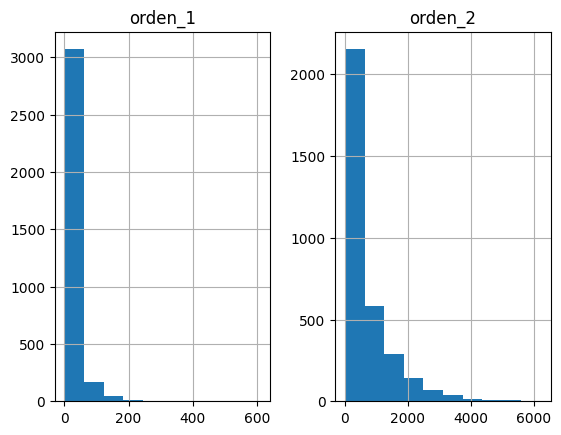

In [16]:
tamaños_df.hist()

# Priorización en entornos

Tengo que implementar esto pero además quiero ver si puedo tener en cuenta que haya asociaciones positivas también en el entorno... esto en general lo vengo ignorando pero temo que me esté empeorando las evaluaciones !

Tengo que tomar por cada gen, una asociación positiva con una enfermedad. Después priorizar esa enfermedad contra todos los genes del entorno, y ver donde queda rankeado el gen original. Si puedo, teniendo en cuenta si hay más de una asociación positiva con la misma enfermedad en ese entorno. 

Para tener en cuenta cuando hay más de una asoc positiva en un ranking, sacar las otras del ranking... DUH

In [17]:
gn_test

,node_name,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
node_index,,,,,,,,,,,,,,,,,,,,,
1,NAT2,NAT2,NAT1,ASAH1,PCM1,FGL1,MTUS1,MTMR7,CNOT7,VPS37A,...,CNTNAP2,CUL1,EZH2,PDIA4,GIMAP1,KRBA1,KCNH2,ATG9B,NOS3,ABCB8
2,ADA,SERINC3,ADA,WISP2,HNF4A,FITM2,TOX2,MYBL2,IFT52,SGK2,...,THBD,SSTR4,FOXA2,PAX1,XRN2,KIZ,NAA20,INSM1,DTD1,SEC23B
3,CDH2,CDH2,CHST9,AQP4,KCTD1,TAF4B,SS18,IMPACT,CABYR,LAMA3,...,CHMP6,RPTOR,NPTX1,ENDOV,RNF213,SGSH,CARD14,EIF4A3,GAA,CCDC40
4,AKT3,AKT3,SDCCAG8,ZBTB18,EXO1,OPN3,COX20,KMO,HNRNPU,FH,...,MCM10,PHYH,BEND7,FRMD4A,CDNF,HSPA14,SUV39H2,DCLRE1C,ACBD7,RPP38
8197,KPNA2,KPNA2,BPTF,NOL11,PSMD12,HELZ,CACNG5,PRKCA,CD79B,ICAM2,...,DLX4,KAT7,SPOP,NXPH3,NGFR,PHB,PHOSPHO1,ABI3,GNGT2,IGF2BP1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16373,MEGF10,MEGF10,LMNB1,PHAX,ALDH7A1,CEP120,PRDM6,SNX24,SNX2,SNCAIP,...,RASGRF2,SSBP2,ATG10,RPS23,XRCC4,VCAN,HAPLN1,EDIL3,RASA1,COX7C
8184,KLRC2,KLRC2,KLRK1,MAGOHB,KLRD1,OLR1,STYK1,PRB3,CLEC7A,ETV6,...,KCNA6,NDUFA9,AKAP3,DYRK4,C12orf4,FGF6,FGF23,TIGAR,CCND2,TEAD4
8187,KNG1,KNG1,HRG,AHSG,DNAJB11,CRYGS,ETV5,TRA2B,IGF2BP2,SENP2,...,RNF13,WWTR1,CP,HPS3,HLTF,AGTR1,ZIC1,GYG1,PLSCR1,PLSCR4


Quiero ver si en todas las filas aparece el gen central dentro del vecindario

In [18]:
aver = gn_test.apply(lambda x: str(x["node_name"]) in str(x[[*range(100)]]), axis=1)
all(aver.value_counts())

True

In [19]:
name_to_index_map = node_df[node_df.node_type == "gene_protein"].drop_duplicates(subset="node_name").reset_index(drop=False).set_index("node_name").node_index.to_dict()

Bueno agarré un ejemplo y salio lindo que se yo

In [20]:
gn_test

,node_name,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
node_index,,,,,,,,,,,,,,,,,,,,,
1,NAT2,NAT2,NAT1,ASAH1,PCM1,FGL1,MTUS1,MTMR7,CNOT7,VPS37A,...,CNTNAP2,CUL1,EZH2,PDIA4,GIMAP1,KRBA1,KCNH2,ATG9B,NOS3,ABCB8
2,ADA,SERINC3,ADA,WISP2,HNF4A,FITM2,TOX2,MYBL2,IFT52,SGK2,...,THBD,SSTR4,FOXA2,PAX1,XRN2,KIZ,NAA20,INSM1,DTD1,SEC23B
3,CDH2,CDH2,CHST9,AQP4,KCTD1,TAF4B,SS18,IMPACT,CABYR,LAMA3,...,CHMP6,RPTOR,NPTX1,ENDOV,RNF213,SGSH,CARD14,EIF4A3,GAA,CCDC40
4,AKT3,AKT3,SDCCAG8,ZBTB18,EXO1,OPN3,COX20,KMO,HNRNPU,FH,...,MCM10,PHYH,BEND7,FRMD4A,CDNF,HSPA14,SUV39H2,DCLRE1C,ACBD7,RPP38
8197,KPNA2,KPNA2,BPTF,NOL11,PSMD12,HELZ,CACNG5,PRKCA,CD79B,ICAM2,...,DLX4,KAT7,SPOP,NXPH3,NGFR,PHB,PHOSPHO1,ABI3,GNGT2,IGF2BP1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16373,MEGF10,MEGF10,LMNB1,PHAX,ALDH7A1,CEP120,PRDM6,SNX24,SNX2,SNCAIP,...,RASGRF2,SSBP2,ATG10,RPS23,XRCC4,VCAN,HAPLN1,EDIL3,RASA1,COX7C
8184,KLRC2,KLRC2,KLRK1,MAGOHB,KLRD1,OLR1,STYK1,PRB3,CLEC7A,ETV6,...,KCNA6,NDUFA9,AKAP3,DYRK4,C12orf4,FGF6,FGF23,TIGAR,CCND2,TEAD4
8187,KNG1,KNG1,HRG,AHSG,DNAJB11,CRYGS,ETV5,TRA2B,IGF2BP2,SENP2,...,RNF13,WWTR1,CP,HPS3,HLTF,AGTR1,ZIC1,GYG1,PLSCR1,PLSCR4


In [154]:
gen = 8184
k = [10,20]

asociaciones_conocidas = new_edges[new_edges.gene_protein == gen ].disease.values
source = asociaciones_conocidas[0]
otras_asoc = mapped_df[(mapped_df.disease == source)&((mapped_df.label == 1)|(mapped_df.edge_type == "message_passing")) & (mapped_df.gene_protein != gen)].gene_protein.values

Entorno genómico

In [155]:
vecindario_genomico = gn_test.loc[gen].replace(name_to_index_map).unique()
targets_genomicos = [g for g in vecindario_genomico if g not in otras_asoc]

print(100 - len(targets_genomicos))
ranking, scores = predictor.prioritize_one_vs_all(source,targets_genomicos)
rank = np.where(ranking == gen)[0][0] + 1
reciprocal_rank = 1/rank

0


1

Entorno topológico

In [160]:
vecindario_topologico_1 = orden_1[gen] + [gen]
vecindario_topologico_2 = orden_2[gen] + [gen]

targets_topologicos_1 = [g for g in vecindario_topologico_1 if g not in otras_asoc]
targets_topologicos_2 = [g for g in vecindario_topologico_2 if g not in otras_asoc]

print(len(vecindario_topologico_1) - len(targets_topologicos_1))
print(len(vecindario_topologico_2) - len(targets_topologicos_2))
ranking, scores = predictor.prioritize_one_vs_all(source, targets_topologicos_2)
rank = np.where(ranking == gen)[0][0] + 1
rank

0
1


1

Generalizo

In [178]:
k = [10,20]
referencia_querys_g = []
referencia_querys_d = []

rank_genomico = []
espacio_genomico = []

rank_topologico_1 = []
rank_topologico_2 = []

espacio_topologico_1 = []
espacio_topologico_2 = []

for i,gen in enumerate(gn_test.index.values):
    print(f"{i} of {len(gn_test)}")
    asociaciones_conocidas = new_edges[new_edges.gene_protein == gen ].disease.values

    vecindario_genomico = gn_test.loc[gen].replace(name_to_index_map).unique()
    vecindario_topologico_1 = orden_1[gen] + [gen]
    vecindario_topologico_2 = orden_2[gen] + [gen]

    for source in asociaciones_conocidas:
        referencia_querys_g.append(gen)
        referencia_querys_d.append(source)

        otras_asoc = mapped_df[(mapped_df.disease == source)&((mapped_df.label == 1)|(mapped_df.edge_type == "message_passing")) & (mapped_df.gene_protein != gen)].gene_protein.values

        targets_genomicos = [g for g in vecindario_genomico if g not in otras_asoc]
        
        #Los que saqué porque son otras asoc. positivas y no quiero ensuciar el ranking, si son muchos me achica el espacio de busqueda y hay que tenerlo en cuenta
        espacio_genomico.append(len(targets_genomicos))
        ranking, scores = predictor.prioritize_one_vs_all(source,targets_genomicos)
        rank_genomico.append(np.where(ranking == gen)[0][0] + 1)

        vecindario_topologico_1 = orden_1[gen] + [gen]
        vecindario_topologico_2 = orden_2[gen] + [gen]

        targets_topologicos_1 = [g for g in vecindario_topologico_1 if g not in otras_asoc]
        targets_topologicos_2 = [g for g in vecindario_topologico_2 if g not in otras_asoc]

        #Los entornos de orden 1 y 2 de las proteínas pueden variar mucho 
        espacio_topologico_1.append(len(targets_topologicos_1))
        espacio_topologico_2.append(len(targets_topologicos_2))

        ranking, scores = predictor.prioritize_one_vs_all(source, targets_topologicos_1)
        rank_topologico_1.append(np.where(ranking == gen)[0][0] + 1)
        
        ranking, scores = predictor.prioritize_one_vs_all(source, targets_topologicos_2)
        rank_topologico_2.append(np.where(ranking == gen)[0][0] + 1)


results = pd.DataFrame({"gene":referencia_querys_g, "disease":referencia_querys_d, "rank_genomico":rank_genomico, "rank_topologico_1":rank_topologico_1, "rank_topologico_2":rank_topologico_2, "espacio_genomico":espacio_genomico, "espacio_topologico_1":espacio_topologico_1, "espacio_topologico_2":espacio_topologico_2})

results.to_csv(reports_folder + "neighborhood_eval/ranks.csv")

0 of 3207
1 of 3207
2 of 3207
3 of 3207
4 of 3207
5 of 3207
6 of 3207
7 of 3207
8 of 3207
9 of 3207
10 of 3207
11 of 3207
12 of 3207
13 of 3207
14 of 3207
15 of 3207
16 of 3207
17 of 3207
18 of 3207
19 of 3207
20 of 3207
21 of 3207
22 of 3207
23 of 3207
24 of 3207
25 of 3207
26 of 3207
27 of 3207
28 of 3207
29 of 3207
30 of 3207
31 of 3207
32 of 3207
33 of 3207
34 of 3207
35 of 3207
36 of 3207
37 of 3207
38 of 3207
39 of 3207
40 of 3207
41 of 3207
42 of 3207
43 of 3207
44 of 3207
45 of 3207
46 of 3207
47 of 3207
48 of 3207
49 of 3207
50 of 3207
51 of 3207
52 of 3207
53 of 3207
54 of 3207
55 of 3207
56 of 3207
57 of 3207
58 of 3207
59 of 3207
60 of 3207
61 of 3207
62 of 3207
63 of 3207
64 of 3207
65 of 3207
66 of 3207
67 of 3207
68 of 3207
69 of 3207
70 of 3207
71 of 3207
72 of 3207
73 of 3207
74 of 3207
75 of 3207
76 of 3207
77 of 3207
78 of 3207
79 of 3207
80 of 3207
81 of 3207
82 of 3207
83 of 3207
84 of 3207
85 of 3207
86 of 3207
87 of 3207
88 of 3207
89 of 3207
90 of 3207
91 of 320

OSError: Cannot save file into a non-existent directory: '../../../reports/explore_predictions/neighborhood_eval'

In [5]:
# results.to_csv(reports_folder + "neighborhood_eval/ranks.csv")
results = pd.read_csv(reports_folder + "neighborhood_eval/ranks.csv", index_col=0)
results

,gene,disease,rank_genomico,rank_topologico_1,rank_topologico_2,espacio_genomico,espacio_topologico_1,espacio_topologico_2
0,1,25098,1,1,1,100,6,153
1,1,21061,2,1,2,99,6,153
2,2,22141,25,2,35,100,5,183
3,2,28892,1,1,2,100,5,183
4,2,21909,30,4,76,100,5,183
...,...,...,...,...,...,...,...,...
7137,8187,30398,27,7,198,100,24,634
7138,8187,22280,3,1,14,100,24,628
7139,8187,29533,1,1,3,98,23,614
7140,8189,20160,31,3,374,100,8,1122


In [6]:
results.describe()

,gene,disease,rank_genomico,rank_topologico_1,rank_topologico_2,espacio_genomico,espacio_topologico_1,espacio_topologico_2
count,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000
mean,9331.025063,23936.526883,13.971017,5.269112,119.284094,98.851722,27.761411,790.880986
std,4778.810005,4436.441058,21.484694,14.203005,317.849647,2.086290,51.873349,989.547990
min,1.000000,18432.000000,1.000000,1.000000,1.000000,77.000000,1.000000,1.000000
25%,5365.000000,20065.000000,1.000000,1.000000,2.000000,99.000000,5.000000,116.000000
50%,9306.500000,22838.000000,3.000000,1.000000,11.000000,100.000000,12.000000,410.500000
75%,13596.000000,26347.500000,16.000000,4.000000,70.000000,100.000000,29.000000,1067.000000
max,18429.000000,34169.000000,100.000000,412.000000,4171.000000,100.000000,612.000000,6227.000000


<AxesSubplot:xlabel='rank_genomico', ylabel='Count'>

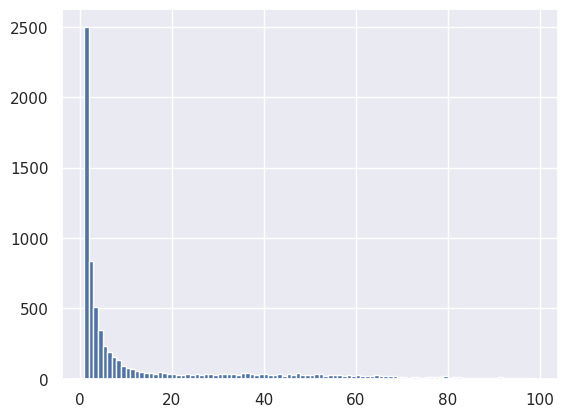

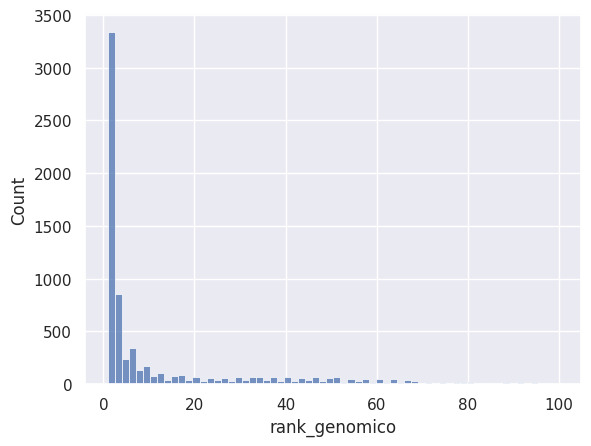

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure()
plt.hist(results.rank_genomico.values,bins=[*range(1,100)])

plt.figure()
sns.histplot(results, x="rank_genomico")

<AxesSubplot:xlabel='rank_genomico', ylabel='Proportion'>

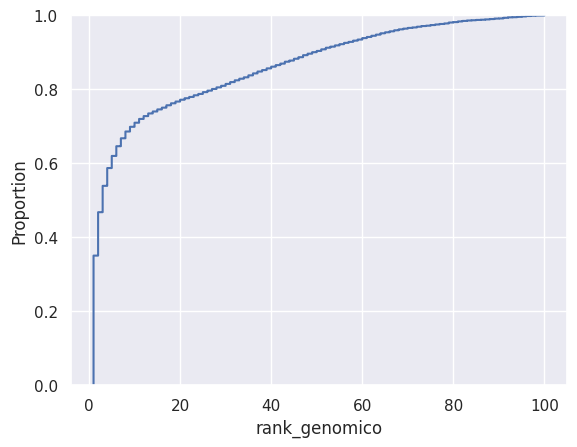

In [27]:
import seaborn as sns
sns.set_theme()

sns.ecdfplot(results, x="rank_genomico")

In [14]:
results

,gene,disease,rank_genomico,rank_topologico_1,rank_topologico_2,espacio_genomico,espacio_topologico_1,espacio_topologico_2
0,1,25098,1,1,1,100,6,153
1,1,21061,2,1,2,99,6,153
2,2,22141,25,2,35,100,5,183
3,2,28892,1,1,2,100,5,183
4,2,21909,30,4,76,100,5,183
...,...,...,...,...,...,...,...,...
7137,8187,30398,27,7,198,100,24,634
7138,8187,22280,3,1,14,100,24,628
7139,8187,29533,1,1,3,98,23,614
7140,8189,20160,31,3,374,100,8,1122


Mean Reciprocal Rank (MRR)

In [25]:
mrr_genomico = sum(1/results["rank_genomico"]) / len(results)
mrr_topologico_1 = sum(1/results["rank_topologico_1"]) / len(results)
mrr_topologico_2 = sum(1/results["rank_topologico_2"]) / len(results)

print(f"MRR genomico: {round(mrr_genomico,2)} \nMRR topológico 1: {round(mrr_topologico_1,2)} \nMRR topológico 2: {round(mrr_topologico_2,2)}")

MRR genomico: 0.47 
MRR topológico 1: 0.65 
MRR topológico 2: 0.32


MRR $\approx$ 0.5 significa que, en promedio, el gen correcto quedó en el puesto 2 de 100 para los query que hicimos. Mayor a 0.5 implica que quedó más veces en el puesto 1, cerca de 0.3 quedó en el puesto 3 y así..

Igual para el caso topológico hay que mirarlo con más cuidado porque los entornos tienen distintos tamaños, no da lo mismo ubicar al gen en el puesto 2 de 2 que en el puesto 2 de 100...

Hay que dividir el ranking topológico en casos, el genómico creo que el resultado se interpreta bien porque todas las listas tienen el mismo tamaño.

Hits at K 

In [37]:
hits_5_genomico = sum(results["rank_genomico"] < 5)/len(results)
hits_10_genomico = sum(results["rank_genomico"] < 10)/len(results)

print(f"Hits@5: {round(hits_5_genomico,2)} \nHits@10: {round(hits_10_genomico,2)}")

Hits@5: 0.59 
Hits@10: 0.7


Hits@k $\approx$ 0.6 significa que en el 60% de los casos, el gen correcto cayó en el top 5 de la lista, Hits@k = 0.7 que el 70% de los casos cayó en el top 10.

Separo rank topológico en casos

In [48]:
def group_by_range(data_df,group_column,ranges,inplace=True):
    if not inplace:
        df = data_df.copy()
        bins = np.digitize(df[group_column].values, ranges)
        df["bins"] = bins
        return df
    else:
        df = data_df
        bins = np.digitize(df[group_column].values, ranges)
        df["bins"] = bins

In [68]:
results_bineado = group_by_range(results,"espacio_topologico_1",np.array([5,10,50,100,results.espacio_topologico_1.max()+1]).astype(int),False)
results_bineado = results_bineado.rename(columns={"bins":"bins_topologico_1"})

results_bineado = group_by_range(results_bineado, "espacio_topologico_2",np.array([10,100,500,1000,results.espacio_topologico_2.max()+1]).astype(int),False)
results_bineado = results_bineado.rename(columns={"bins":"bins_topologico_2"})

results_bineado

,gene,disease,rank_genomico,rank_topologico_1,rank_topologico_2,espacio_genomico,espacio_topologico_1,espacio_topologico_2,bins_topologico_1,bins_topologico_2
0,1,25098,1,1,1,100,6,153,1,2
1,1,21061,2,1,2,99,6,153,1,2
2,2,22141,25,2,35,100,5,183,1,2
3,2,28892,1,1,2,100,5,183,1,2
4,2,21909,30,4,76,100,5,183,1,2
...,...,...,...,...,...,...,...,...,...,...
7137,8187,30398,27,7,198,100,24,634,2,3
7138,8187,22280,3,1,14,100,24,628,2,3
7139,8187,29533,1,1,3,98,23,614,2,3
7140,8189,20160,31,3,374,100,8,1122,1,4


In [72]:
results_bineado["reciprocal_rank_k1"] = 1/results_bineado["rank_topologico_1"]
results_bineado["reciprocal_rank_k2"] = 1/results_bineado["rank_topologico_2"]

# mrr_topologico_1 = sum(1/results["rank_topologico_1"]) / len(results)
# mrr_topologico_2 = sum(1/results["rank_topologico_2"]) / len(results)

# hits_5_genomico = sum(results["rank_genomico"] < 5)/len(results)
# hits_10_genomico = sum(results["rank_genomico"] < 10)/len(results)

mrr_topologico_1 = results_bineado[["reciprocal_rank_k1","bins_topologico_1"]].groupby("bins_topologico_1").mean().rename(co)

,reciprocal_rank_k1
bins_topologico_1,
0,0.861941
1,0.743626
2,0.583558
3,0.389598
4,0.288747
